# LSTM

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Conv2D, Flatten, Reshape, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from keras.layers import Bidirectional

In [3]:
import data_processing
import feature_extraction

In [4]:
df = data_processing.read_all_users('geolife_trajectories')
df = data_processing.process_classes(df)
df = data_processing.drop_unlabelled(df)

[1/182] processing user 135
[2/182] processing user 132
[3/182] processing user 104
[4/182] processing user 103
[5/182] processing user 168
[6/182] processing user 157
[7/182] processing user 150
[8/182] processing user 159
[9/182] processing user 166
[10/182] processing user 161
[11/182] processing user 102
[12/182] processing user 105
[13/182] processing user 133
[14/182] processing user 134
[15/182] processing user 160
[16/182] processing user 158
[17/182] processing user 167
[18/182] processing user 151
[19/182] processing user 169
[20/182] processing user 156
[21/182] processing user 024
[22/182] processing user 023
[23/182] processing user 015
[24/182] processing user 012
[25/182] processing user 079
[26/182] processing user 046
[27/182] processing user 041
[28/182] processing user 048
[29/182] processing user 077
[30/182] processing user 083
[31/182] processing user 084
[32/182] processing user 070
[33/182] processing user 013
[34/182] processing user 014
[35/182] processing use

In [5]:
df = data_processing.create_segments(df)
df = data_processing.calculations(df)
df = data_processing.filter(df)

In [6]:
updated_df = pd.read_pickle("updated_df_fifteen.pkl")

In [7]:
time_series_features = ['speed', 'acceleration','jerk','heading_change','angular_velocity', 'angular_acceleration']

In [8]:
columns = ['speed', 'acceleration','jerk','heading_change','angular_velocity', 'angular_acceleration']

global_mins = {}
global_maxs = {}

for col in columns:
    # Get min/max from both datasets
    min1 = df[col].min()
    max1 = df[col].max()
    min2 = updated_df[col].min()
    max2 = updated_df[col].max()
    
    # Compute global values
    global_mins[col] = min(min1, min2)
    global_maxs[col] = max(max1, max2)

print("Global Minimums:", global_mins)
print("Global Maximums:", global_maxs)

Global Minimums: {'speed': 0.00022085781252921755, 'acceleration': -1878.88247646102, 'jerk': -2846.625663814707, 'heading_change': 0.0, 'angular_velocity': 0.0, 'angular_acceleration': -180.0}
Global Maximums: {'speed': 293.3060715168033, 'acceleration': 246.93771635310583, 'jerk': 765922.0469761436, 'heading_change': 180.0, 'angular_velocity': 180.0, 'angular_acceleration': 180.0}


In [9]:
def normalize_features(df, global_mins, global_maxs):
    """
    Normalize features using precomputed global min/max
    """
    normalized_df = df.copy()
    for feature in ['speed', 'acceleration','jerk','heading_change','angular_velocity', 'angular_acceleration']:  # Your 3 features
        min_val = global_mins[feature]
        max_val = global_maxs[feature]
        
        # Avoid division by zero (use epsilon if max == min)
        denominator = max_val - min_val
        if denominator == 0:
            denominator = 1  # Or use a small epsilon (e.g., 1e-8)
        
        normalized_df[feature] = (df[feature] - min_val) / denominator
    
    return normalized_df

# Normalize both datasets
df = normalize_features(df, global_mins, global_maxs)
updated_df = normalize_features(updated_df, global_mins, global_maxs)

print("Normalized Dataset 1:")
print(df)
print("\nNormalized Dataset 2:")
print(updated_df)

Normalized Dataset 1:
               lat         lon         alt  elapsed time                time  \
0        39.976200  116.330383  229.658793  39184.432917 2007-04-12 10:23:24   
1        39.976033  116.330367  259.186352  39184.434132 2007-04-12 10:25:09   
2        39.975817  116.330300  275.590551  39184.434398 2007-04-12 10:25:32   
3        39.975700  116.330333  295.275591  39184.435613 2007-04-12 10:27:17   
4        39.975383  116.330667  137.795276  39184.611030 2007-04-12 14:39:53   
...            ...         ...         ...           ...                 ...   
4166298  39.991613  116.330468    0.000000  40908.637292 2011-12-31 15:17:42   
4166299  39.991615  116.330483    0.000000  40908.637350 2011-12-31 15:17:47   
4166300  39.991630  116.330473    0.000000  40908.637407 2011-12-31 15:17:52   
4166301  39.991642  116.330465    0.000000  40908.637465 2011-12-31 15:17:57   
4166302  39.991670  116.330468    0.000000  40908.637523 2011-12-31 15:18:02   

                 

In [10]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [11]:
X_sequences = []
y_sequences = []

for _, group in df.groupby('segment'):
    X_sequences.append(group[time_series_features].values)  # Raw sequences
    y_sequences.append(group['label'].iloc[0])  # Assign one label per segment

In [12]:
for i, seq in enumerate(X_sequences):
    print(f"Shape of sequence {i}: {seq.shape}")

Shape of sequence 0: (4, 6)
Shape of sequence 1: (44, 6)
Shape of sequence 2: (22, 6)
Shape of sequence 3: (38, 6)
Shape of sequence 4: (28, 6)
Shape of sequence 5: (44, 6)
Shape of sequence 6: (21, 6)
Shape of sequence 7: (4, 6)
Shape of sequence 8: (23, 6)
Shape of sequence 9: (23, 6)
Shape of sequence 10: (14, 6)
Shape of sequence 11: (2, 6)
Shape of sequence 12: (81, 6)
Shape of sequence 13: (73, 6)
Shape of sequence 14: (112, 6)
Shape of sequence 15: (20, 6)
Shape of sequence 16: (68, 6)
Shape of sequence 17: (8, 6)
Shape of sequence 18: (31, 6)
Shape of sequence 19: (8, 6)
Shape of sequence 20: (27, 6)
Shape of sequence 21: (348, 6)
Shape of sequence 22: (229, 6)
Shape of sequence 23: (30, 6)
Shape of sequence 24: (13, 6)
Shape of sequence 25: (160, 6)
Shape of sequence 26: (125, 6)
Shape of sequence 27: (304, 6)
Shape of sequence 28: (48, 6)
Shape of sequence 29: (40, 6)
Shape of sequence 30: (93, 6)
Shape of sequence 31: (96, 6)
Shape of sequence 32: (415, 6)
Shape of sequence 

In [13]:
# Convert labels to one-hot encoding
y_sequences = to_categorical(y_sequences)
y_sequences

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=19)

In [15]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=19)

In [ ]:
def create_rolling_windows(X_sequences, y_sequences, window_size=200, step=100):
    """
    Creates rolling window segments from time-series data, padding short sequences at the beginning.
    
    Parameters:
    - X_sequences: List of time-series feature sequences (NumPy arrays)
    - y_sequences: List of corresponding labels.
    - window_size: Number of time steps per window
    - step: Step size between windows (e.g., 10 for overlap)
    
    Returns:
    - X_windows: NumPy array of rolling window samples
    - y_windows: NumPy array of labels
    """
    X_windows = []
    y_windows = []

    for i in range(len(X_sequences)):  # Loop through sequences
        seq = X_sequences[i]  # Extract single trajectory
        label = y_sequences[i]  # Corresponding label

        # If sequence is shorter than window_size, pad at the beginning
        if len(seq) < window_size:
            pad_length = window_size - len(seq)
            pad = np.zeros((pad_length, seq.shape[1]))  # Create zero padding
            seq = np.vstack((seq, pad))  

            # Add the single padded sequence
            X_windows.append(seq)
            y_windows.append(label)
            continue  # Skip rolling window logic for this sequence

        # Create rolling windows within the sequence
        for j in range(0, len(seq) - window_size + 1, step):
            X_windows.append(seq[j:j + window_size])  # Extract window
            y_windows.append(label)  # Use the same label for entire window

    return np.array(X_windows), np.array(y_windows)

In [17]:
# Set parameters
window_size = 200  # Length of each segment
step_size = 100  # Step between windows

# Create rolling windows
X_train2, y_train2 = create_rolling_windows(X_train2, y_train2, window_size, step_size)

# Verify shape
print("Shape of X_train:", X_train2.shape)
print("Shape of y_train:", y_train2.shape)

Shape of X_train: (25094, 200, 6)
Shape of y_train: (25094, 5)


In [18]:
X_test, y_test = create_rolling_windows(X_test, y_test, window_size, step_size)

# Verify shape
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_test: (7504, 200, 6)
Shape of y_test: (7504, 5)


In [19]:
# Create rolling windows
X_val, y_val = create_rolling_windows(X_val, y_val, window_size, step_size)

# Verify shape
print("Shape of X_val", X_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_val (2669, 200, 6)
Shape of y_val: (2669, 5)


In [20]:
def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    
    # LSTM Layers
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))  # First LSTM layer with input shape
    model.add(Dropout(0.3))
    
    model.add(LSTM(64))  # Final LSTM layer
    model.add(Dropout(0.3))
    
    # Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [21]:
input_shape = (X_train2.shape[1], X_train2.shape[2])  # (time_steps, features)
num_classes = y_train.shape[1]
model = create_lstm_model(input_shape, num_classes)

model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 200, 128)       │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,933 (488.02 KB)

 Trainable params: 124,933 (488.02 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model to best state
)

# Train the model
history = model.fit(X_train2, y_train2, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 350s 445ms/step - accuracy: 0.3143 - loss: 1.5192 - val_accuracy: 0.2345 - val_loss: 1.5768 - learning_rate: 0.0010
Epoch 2/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 3316s 4s/step - accuracy: 0.3266 - loss: 1.5025 - val_accuracy: 0.5425 - val_loss: 1.1647 - learning_rate: 0.0010
Epoch 3/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 120s 153ms/step - accuracy: 0.5300 - loss: 1.1804 - val_accuracy: 0.4432 - val_loss: 1.3700 - learning_rate: 0.0010
Epoch 4/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 115s 146ms/step - accuracy: 0.4653 - loss: 1.3044 - val_accuracy: 0.4830 - val_loss: 1.2782 - learning_rate: 0.0010
Epoch 5/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 112s 142ms/step - accuracy: 0.4865 - loss: 1.2421 - val_accuracy: 0.5332 - val_loss: 1.1174 - learning_rate: 0.0010
Epoch 6/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 116s 148ms/step - accuracy: 0.5669 - loss: 1.0830 - val_accuracy: 0.6126 - val_loss: 0.9537 - learning_rate: 0.0010
Epoch 7/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 111s 141ms/step - accuracy

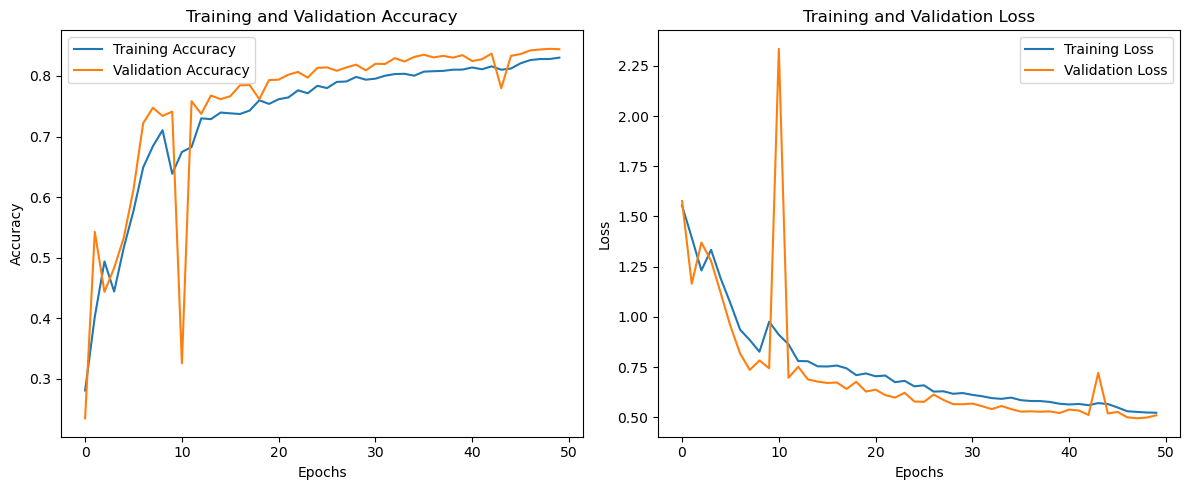

235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step
Classification Report:
               precision    recall  f1-score   support

        bike      0.926     0.852     0.887      1022
         bus      0.857     0.728     0.787      1818
         car      0.664     0.755     0.707      1026
       train      0.964     0.905     0.934      1838
        walk      0.834     0.985     0.903      1800

    accuracy                          0.854      7504
   macro avg      0.849     0.845     0.844      7504
weighted avg      0.861     0.854     0.854      7504



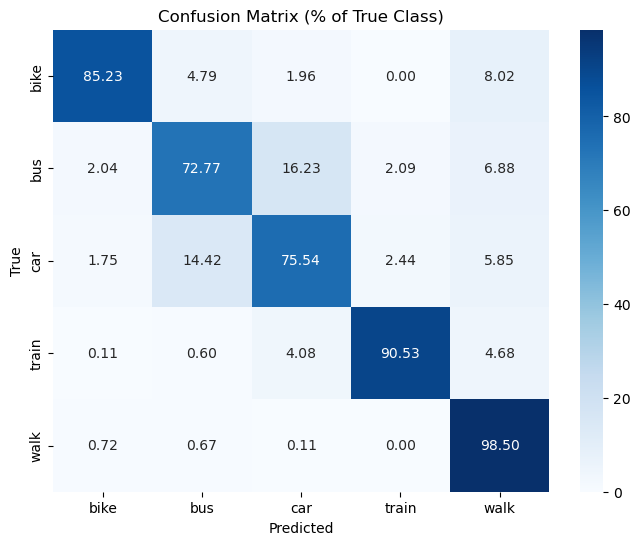

In [23]:
# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report with TRUE LABELS
print("Classification Report:\n", 
      classification_report(
          y_true_classes, 
          y_pred_classes, 
          target_names=label_encoder.classes_, digits=3  # Add class names here
      ))

# Confusion Matrix in percentages
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_percent, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=label_encoder.classes_,  # True labels for axes
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (% of True Class)")
plt.show()

In [24]:

def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    
    # Bidirectional LSTM Layers
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.3))
    
    model.add(Bidirectional(LSTM(64)))  # Final BiLSTM layer
    model.add(Dropout(0.3))
    
    # Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [25]:
input_shape = (X_train2.shape[1], X_train2.shape[2])  # (time_steps, features)
num_classes = y_train.shape[1]
modelbi = create_lstm_model(input_shape, num_classes)

modelbi.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 200, 256)       │       138,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 313,093 (1.19 MB)

 Trainable params: 313,093 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model to best state
)

# Train the model
history = modelbi.fit(X_train2, y_train2, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 261s 330ms/step - accuracy: 0.4995 - loss: 1.2202 - val_accuracy: 0.5916 - val_loss: 1.0787 - learning_rate: 0.0010
Epoch 2/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 290s 369ms/step - accuracy: 0.5882 - loss: 1.0349 - val_accuracy: 0.6186 - val_loss: 1.0178 - learning_rate: 0.0010
Epoch 3/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 292s 372ms/step - accuracy: 0.4356 - loss: 1.3825 - val_accuracy: 0.5834 - val_loss: 1.0862 - learning_rate: 0.0010
Epoch 4/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 296s 378ms/step - accuracy: 0.5563 - loss: 1.1061 - val_accuracy: 0.6043 - val_loss: 1.0190 - learning_rate: 0.0010
Epoch 5/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 282s 360ms/step - accuracy: 0.5649 - loss: 1.0935 - val_accuracy: 0.5571 - val_loss: 1.1287 - learning_rate: 0.0010
Epoch 6/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 285s 363ms/step - accuracy: 0.6379 - loss: 0.9481 - val_accuracy: 0.7179 - val_loss: 0.7662 - learning_rate: 5.0000e-04
Epoch 7/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 288s 367ms/step - ac

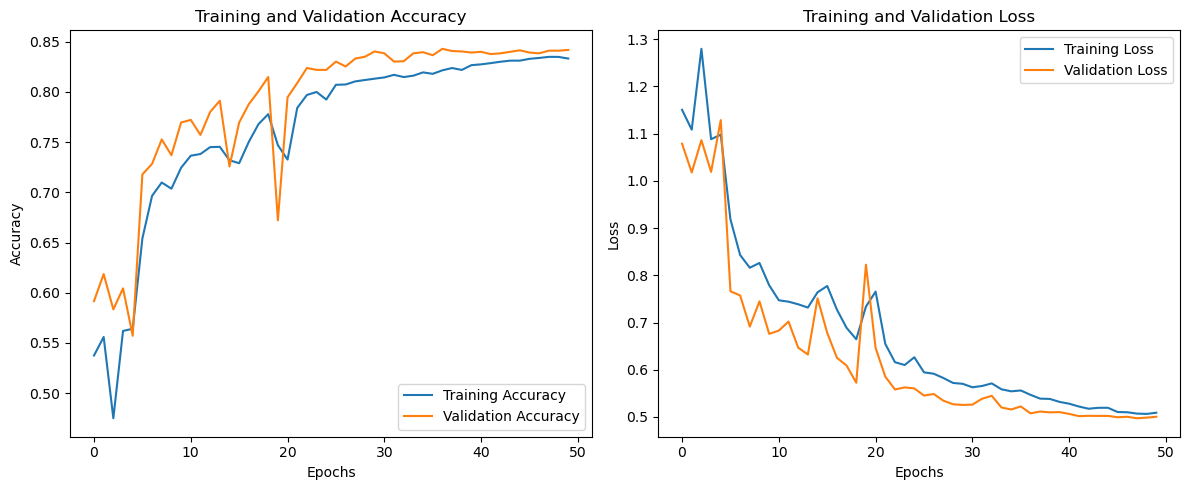

235/235 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step
Classification Report:
               precision    recall  f1-score   support

        bike      0.925     0.853     0.888      1022
         bus      0.845     0.737     0.787      1818
         car      0.659     0.740     0.697      1026
       train      0.967     0.897     0.931      1838
        walk      0.835     0.984     0.904      1800

    accuracy                          0.852      7504
   macro avg      0.846     0.842     0.841      7504
weighted avg      0.858     0.852     0.852      7504



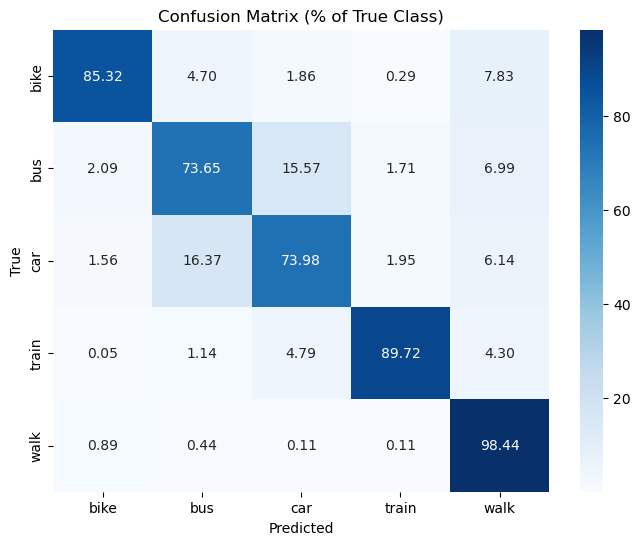

In [27]:
# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Make predictions
y_pred = modelbi.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report with TRUE LABELS
print("Classification Report:\n", 
      classification_report(
          y_true_classes, 
          y_pred_classes, 
          target_names=label_encoder.classes_, digits=3  # Add class names here
      ))

# Confusion Matrix in percentages
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_percent, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=label_encoder.classes_,  # True labels for axes
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (% of True Class)")
plt.show()

In [28]:
time_series_features = ['speed', 'acceleration','jerk', 'angular_acceleration']

In [29]:
X_sequences = []
y_sequences = []

for _, group in df.groupby('segment'):
    X_sequences.append(group[time_series_features].values)  # Raw sequences
    y_sequences.append(group['label'].iloc[0])  # Assign one label per segment

In [30]:
# Convert labels to one-hot encoding
y_sequences = to_categorical(y_sequences)
y_sequences

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=19)

In [32]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=19)

In [33]:
# Create rolling windows
X_train2, y_train2 = create_rolling_windows(X_train2, y_train2, window_size, step_size)

# Verify shape
print("Shape of X_train:", X_train2.shape)
print("Shape of y_train:", y_train2.shape)

Shape of X_train: (25094, 200, 4)
Shape of y_train: (25094, 5)


In [34]:
X_test, y_test = create_rolling_windows(X_test, y_test, window_size, step_size)

# Verify shape
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_test: (7504, 200, 4)
Shape of y_test: (7504, 5)


In [35]:
# Create rolling windows
X_val, y_val = create_rolling_windows(X_val, y_val, window_size, step_size)

# Verify shape
print("Shape of X_val", X_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_val (2669, 200, 4)
Shape of y_val: (2669, 5)


In [36]:
def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    
    # LSTM Layers
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))  # First LSTM layer with input shape
    model.add(Dropout(0.3))
    
    model.add(LSTM(64))  # Final LSTM layer
    model.add(Dropout(0.3))
    
    # Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [37]:
input_shape = (X_train2.shape[1], X_train2.shape[2])  # (time_steps, features)
num_classes = y_train.shape[1]
model2 = create_lstm_model(input_shape, num_classes)

model2.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 200, 128)       │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,909 (484.02 KB)

 Trainable params: 123,909 (484.02 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model to best state
)

# Train the model
history = model2.fit(X_train2, y_train2, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 117s 148ms/step - accuracy: 0.4065 - loss: 1.4034 - val_accuracy: 0.3099 - val_loss: 1.5797 - learning_rate: 0.0010
Epoch 2/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 116s 148ms/step - accuracy: 0.2615 - loss: 1.5843 - val_accuracy: 0.2345 - val_loss: 1.5778 - learning_rate: 0.0010
Epoch 3/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 119s 152ms/step - accuracy: 0.2695 - loss: 1.5798 - val_accuracy: 0.3099 - val_loss: 1.5732 - learning_rate: 0.0010
Epoch 4/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 121s 154ms/step - accuracy: 0.2688 - loss: 1.5741 - val_accuracy: 0.3099 - val_loss: 1.5719 - learning_rate: 0.0010
Epoch 5/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 120s 153ms/step - accuracy: 0.2610 - loss: 1.5794 - val_accuracy: 0.3099 - val_loss: 1.5691 - learning_rate: 0.0010
Epoch 6/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 122s 156ms/step - accuracy: 0.3038 - loss: 1.5457 - val_accuracy: 0.4964 - val_loss: 1.2749 - learning_rate: 0.0010
Epoch 7/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 122s 155ms/step - accura

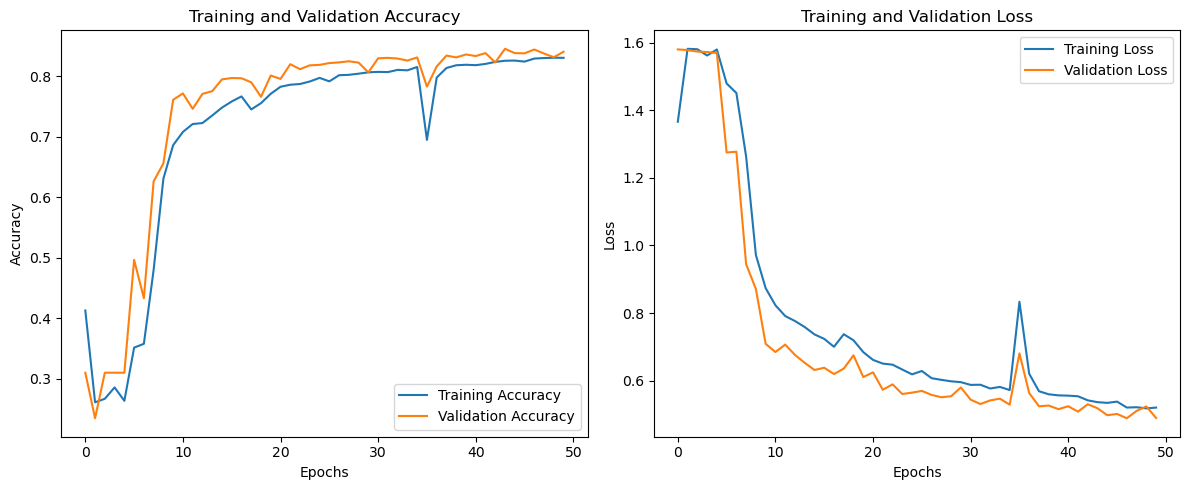

235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step
Classification Report:
               precision    recall  f1-score   support

        bike      0.895     0.881     0.888      1022
         bus      0.855     0.742     0.795      1818
         car      0.672     0.735     0.702      1026
       train      0.956     0.906     0.931      1838
        walk      0.861     0.984     0.919      1800

    accuracy                          0.858      7504
   macro avg      0.848     0.850     0.847      7504
weighted avg      0.862     0.858     0.858      7504



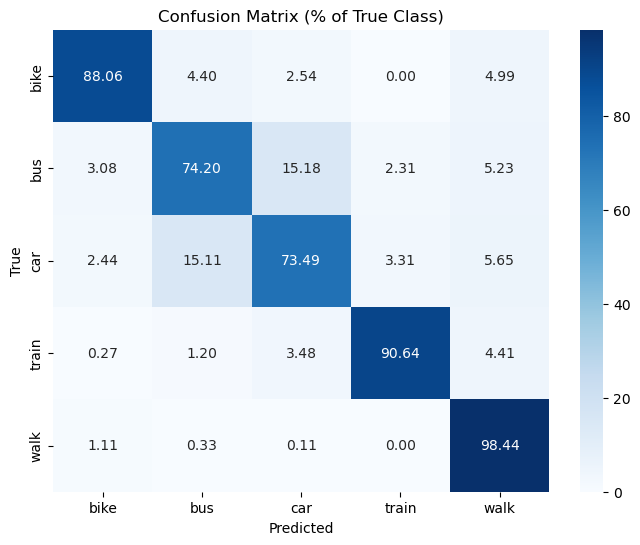

In [39]:
# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Make predictions
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report with TRUE LABELS
print("Classification Report:\n", 
      classification_report(
          y_true_classes, 
          y_pred_classes, 
          target_names=label_encoder.classes_, digits=3  # Add class names here
      ))

# Confusion Matrix in percentages
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_percent, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=label_encoder.classes_,  # True labels for axes
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (% of True Class)")
plt.show()

In [40]:
def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    
    # Bidirectional LSTM Layers
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.3))
    
    model.add(Bidirectional(LSTM(64)))  # Final BiLSTM layer
    model.add(Dropout(0.3))
    
    # Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [41]:
input_shape = (X_train2.shape[1], X_train2.shape[2])  # (time_steps, features)
num_classes = y_train.shape[1]
model2bi = create_lstm_model(input_shape, num_classes)

model2bi.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 200, 256)       │       136,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 200, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311,045 (1.19 MB)

 Trainable params: 311,045 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model to best state
)

# Train the model
history = model2bi.fit(X_train2, y_train2, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 259s 327ms/step - accuracy: 0.4848 - loss: 1.2453 - val_accuracy: 0.5777 - val_loss: 1.0605 - learning_rate: 0.0010
Epoch 2/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 263s 335ms/step - accuracy: 0.5688 - loss: 1.0907 - val_accuracy: 0.4942 - val_loss: 1.1965 - learning_rate: 0.0010
Epoch 3/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 267s 340ms/step - accuracy: 0.4768 - loss: 1.2886 - val_accuracy: 0.3616 - val_loss: 1.3182 - learning_rate: 0.0010
Epoch 4/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 263s 335ms/step - accuracy: 0.4928 - loss: 1.2125 - val_accuracy: 0.4852 - val_loss: 1.2079 - learning_rate: 0.0010
Epoch 5/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 272s 346ms/step - accuracy: 0.5641 - loss: 1.0925 - val_accuracy: 0.6448 - val_loss: 0.9657 - learning_rate: 5.0000e-04
Epoch 6/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 268s 341ms/step - accuracy: 0.6157 - loss: 1.0069 - val_accuracy: 0.5969 - val_loss: 1.0045 - learning_rate: 5.0000e-04
Epoch 7/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 236s 300ms/step 

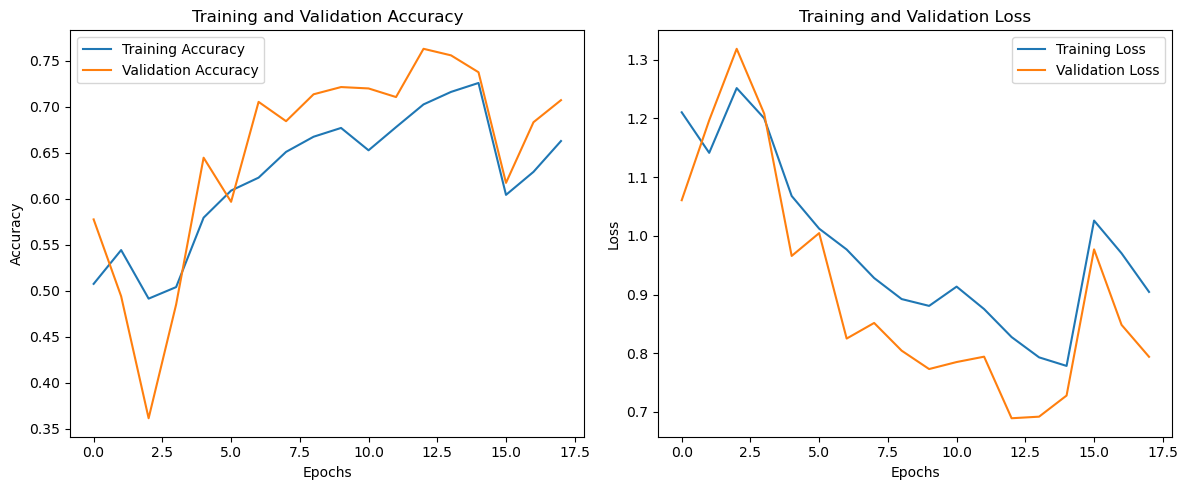

235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 110ms/step
Classification Report:
               precision    recall  f1-score   support

        bike      0.900     0.731     0.807      1022
         bus      0.782     0.692     0.734      1818
         car      0.462     0.470     0.466      1026
       train      0.836     0.781     0.807      1838
        walk      0.773     0.990     0.868      1800

    accuracy                          0.760      7504
   macro avg      0.751     0.733     0.736      7504
weighted avg      0.765     0.760     0.757      7504



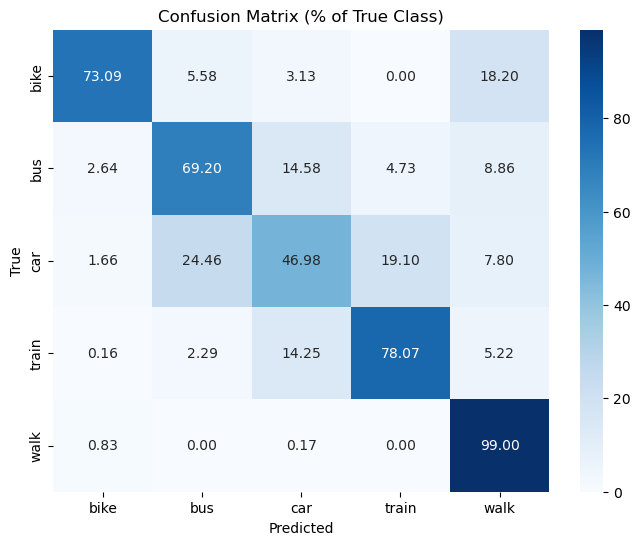

In [43]:
# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Make predictions
y_pred = model2bi.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report with TRUE LABELS
print("Classification Report:\n", 
      classification_report(
          y_true_classes, 
          y_pred_classes, 
          target_names=label_encoder.classes_ , digits=3 # Add class names here
      ))

# Confusion Matrix in percentages
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_percent, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=label_encoder.classes_,  # True labels for axes
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (% of True Class)")
plt.show()

In [44]:
time_series_features = ['speed', 'acceleration','jerk']

In [45]:
X_sequences = []
y_sequences = []

for _, group in df.groupby('segment'):
    X_sequences.append(group[time_series_features].values)  # Raw sequences
    y_sequences.append(group['label'].iloc[0])  # Assign one label per segment

In [46]:
# Convert labels to one-hot encoding
y_sequences = to_categorical(y_sequences)
y_sequences

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=19)

In [48]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=19)

In [49]:
# Create rolling windows
X_train2, y_train2 = create_rolling_windows(X_train2, y_train2, window_size, step_size)

# Verify shape
print("Shape of X_train:", X_train2.shape)
print("Shape of y_train:", y_train2.shape)

Shape of X_train: (25094, 200, 3)
Shape of y_train: (25094, 5)


In [50]:
X_test, y_test = create_rolling_windows(X_test, y_test, window_size, step_size)

# Verify shape
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_test: (7504, 200, 3)
Shape of y_test: (7504, 5)


In [51]:
# Create rolling windows
X_val, y_val = create_rolling_windows(X_val, y_val, window_size, step_size)

# Verify shape
print("Shape of X_val", X_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_val (2669, 200, 3)
Shape of y_val: (2669, 5)


In [60]:
def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    
    # LSTM Layers
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))  # First LSTM layer with input shape
    model.add(Dropout(0.3))
    
    model.add(LSTM(64))  # Final LSTM layer
    model.add(Dropout(0.3))
    
    # Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [61]:
input_shape = (X_train2.shape[1], X_train2.shape[2])  # (time_steps, features)
num_classes = y_train.shape[1]
model3 = create_lstm_model(input_shape, num_classes)

model3.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 200, 128)       │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,397 (482.02 KB)

 Trainable params: 123,397 (482.02 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# Reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model to best state
)

# Train the model
history = model3.fit(X_train2, y_train2, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 106s 132ms/step - accuracy: 0.4040 - loss: 1.3868 - val_accuracy: 0.5377 - val_loss: 1.1972 - learning_rate: 0.0010
Epoch 2/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 100s 127ms/step - accuracy: 0.5273 - loss: 1.1822 - val_accuracy: 0.5646 - val_loss: 1.1938 - learning_rate: 0.0010
Epoch 3/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 1606s 2s/step - accuracy: 0.4387 - loss: 1.3233 - val_accuracy: 0.5826 - val_loss: 1.2365 - learning_rate: 0.0010
Epoch 4/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 813s 1s/step - accuracy: 0.5584 - loss: 1.1265 - val_accuracy: 0.6654 - val_loss: 0.9022 - learning_rate: 0.0010
Epoch 5/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 103s 131ms/step - accuracy: 0.5096 - loss: 1.1983 - val_accuracy: 0.4376 - val_loss: 1.3086 - learning_rate: 0.0010
Epoch 6/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 102s 130ms/step - accuracy: 0.4472 - loss: 1.3147 - val_accuracy: 0.5073 - val_loss: 1.2355 - learning_rate: 0.0010
Epoch 7/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 103s 131ms/step - accuracy: 0

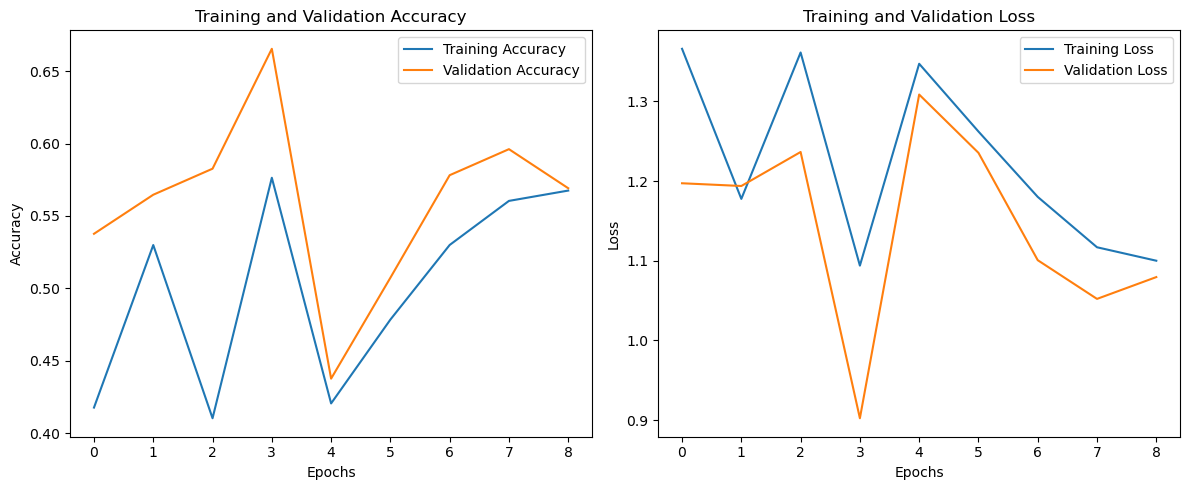

235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step
Classification Report:
               precision    recall  f1-score   support

        bike      0.579     0.497     0.535      1022
         bus      0.585     0.609     0.597      1818
         car      0.398     0.100     0.160      1026
       train      0.719     0.856     0.782      1838
        walk      0.760     0.965     0.850      1800

    accuracy                          0.670      7504
   macro avg      0.608     0.606     0.585      7504
weighted avg      0.633     0.670     0.635      7504



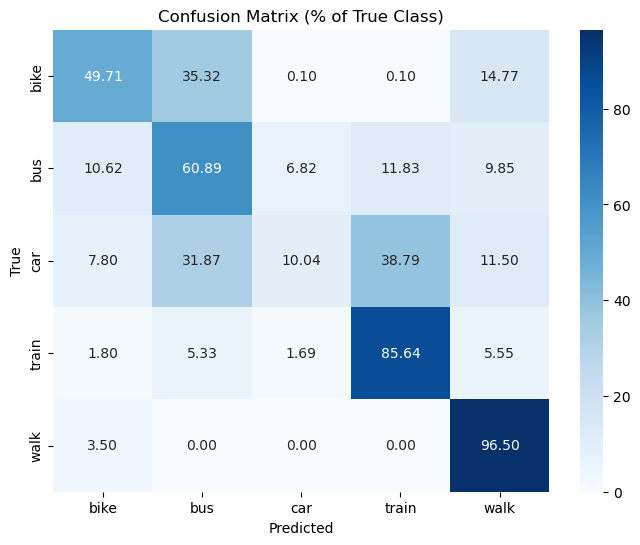

In [63]:
# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Make predictions
y_pred = model3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report with TRUE LABELS
print("Classification Report:\n", 
      classification_report(
          y_true_classes, 
          y_pred_classes, 
          target_names=label_encoder.classes_, digits=3  # Add class names here
      ))

# Confusion Matrix in percentages
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_percent, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=label_encoder.classes_,  # True labels for axes
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (% of True Class)")
plt.show()

In [64]:
def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    
    # Bidirectional LSTM Layers
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.3))
    
    model.add(Bidirectional(LSTM(64)))  # Final BiLSTM layer
    model.add(Dropout(0.3))
    
    # Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [65]:
input_shape = (X_train2.shape[1], X_train2.shape[2])  # (time_steps, features)
num_classes = y_train.shape[1]
model3bi = create_lstm_model(input_shape, num_classes)

model3bi.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 200, 256)       │       135,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 200, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 310,021 (1.18 MB)

 Trainable params: 310,021 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# Reduce learning rate when validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model to best state
)

# Train the model
history = model3bi.fit(X_train2, y_train2, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 235s 297ms/step - accuracy: 0.5198 - loss: 1.1790 - val_accuracy: 0.5223 - val_loss: 1.2039 - learning_rate: 0.0010
Epoch 2/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 239s 304ms/step - accuracy: 0.4706 - loss: 1.2562 - val_accuracy: 0.5939 - val_loss: 1.0456 - learning_rate: 0.0010
Epoch 3/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 239s 305ms/step - accuracy: 0.5622 - loss: 1.0949 - val_accuracy: 0.6336 - val_loss: 0.9659 - learning_rate: 0.0010
Epoch 4/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 237s 302ms/step - accuracy: 0.6181 - loss: 1.0057 - val_accuracy: 0.6163 - val_loss: 1.0607 - learning_rate: 0.0010
Epoch 5/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 238s 303ms/step - accuracy: 0.6474 - loss: 0.9568 - val_accuracy: 0.7553 - val_loss: 0.7507 - learning_rate: 0.0010
Epoch 6/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 236s 301ms/step - accuracy: 0.6779 - loss: 0.8935 - val_accuracy: 0.6426 - val_loss: 0.9395 - learning_rate: 0.0010
Epoch 7/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 238s 303ms/step - accura

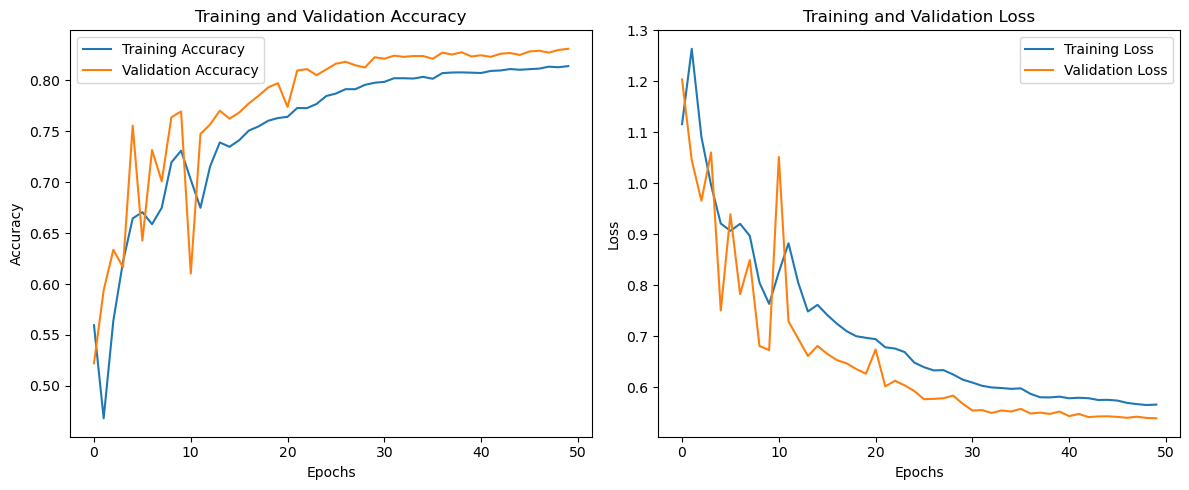

235/235 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step
Classification Report:
               precision    recall  f1-score   support

        bike      0.911     0.847     0.878      1022
         bus      0.853     0.726     0.785      1818
         car      0.652     0.717     0.683      1026
       train      0.950     0.896     0.922      1838
        walk      0.824     0.982     0.896      1800

    accuracy                          0.844      7504
   macro avg      0.838     0.834     0.833      7504
weighted avg      0.850     0.844     0.844      7504



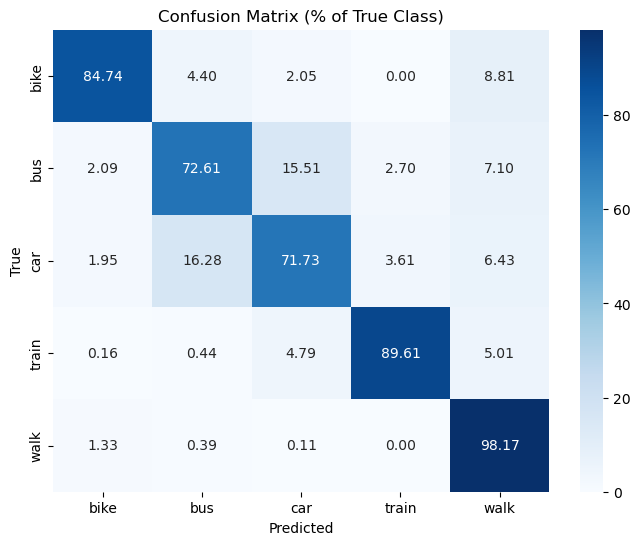

In [67]:
# Plot training history (accuracy and loss)
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Make predictions
y_pred = model3bi.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report with TRUE LABELS
print("Classification Report:\n", 
      classification_report(
          y_true_classes, 
          y_pred_classes, 
          target_names=label_encoder.classes_, digits=3  # Add class names here
      ))

# Confusion Matrix in percentages
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8,6))
sns.heatmap(
    cm_percent, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=label_encoder.classes_,  # True labels for axes
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (% of True Class)")
plt.show()